# Overview
## Project Objectives
This notebook contains my scratch work for wrangling the bakery sales data. I intend to accomplish the following objectives in Explore, so I will wrangle the data appropriately:
1. Understand changes in daily revenue for the timespan covered
    * Explain any anomalies using context (holidays, lockdowns, etc)
2. Calculate exact delivery fee for each transaction
    * Calculate item charges using counts and prices
    * Subtract item charge from total charges to determine delivery fee
3. Analyze delivery fee in the context of delivery location
    * Increased fees with longer delivery is probable
    * Are delivery fees associated with the 'place' or are they more specific?
    * Can we figure out 'close' and 'far' within a place just based on delivery fee differences?
4. Understand delivery locations and their trends
    * Do certain areas order during a certain time of day?
    * Do certain areas purchase more items on average?
    * Do certain areas purchase more in terms of revenue?
    * Did certain areas have increased/decreased activity weeks or months?
    * Do certain areas purchase more of an item than others?
5. Analyze how products sold
    * Which items sold the most?
    * Which items sold the least?
    * Which item had the highest revenue?
    * Are there significant increases or decreases in certain items sold during holidays or otherwise?
    * Are any items being disproportionately bought by certain areas?
6. Create a Tableau heatmap for locations and sales

## Wrangling Steps to Achieve Objectives
To succeed in these objectives, I will need to:
- Clear any nulls out of the datetime column
- Index my data on the datetime column
- Check for outliers in the total charges column (potential for unusually-large transaction charges)
- Create a resampling function to aggregate transactions into daily totals
    * Preserve the original transactions as well
- Eliminate any potential non-business days from the rows
    * Kaggle data overview says Tuesdays are usually closed days
    * Additional expected closed days: holidays, coronavirus-related, etc
    
Once these steps are complete, the data should be ready for exploration.

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import wrangle

# Implementation
Caching data, checking nulls in datetime...

In [2]:
# initial acquisition
sales = pd.read_csv('Bakery Sales.csv')
prices = pd.read_csv('Bakery price.csv')
# check for nulls in datetime
sales[sales.datetime.isna()]

,datetime,day of week,total,place,angbutter,plain bread,jam,americano,croissant,caffe latte,...,gateau chocolat,pandoro,cheese cake,lemon ade,orange pound,wiener,vanila latte,berry ade,tiramisu,merinque cookies
2420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


All nulls in datetime are after row 2419, so I will limit the dataframe to everything up to 2420...

In [3]:
# in sales, drop rows with nulls in datetime column (after index 2419)
sales = sales[sales.datetime.index < 2420]

With non-null rows, will set index to datetime...

In [4]:
# index using datetime
sales.index = pd.to_datetime(sales.datetime)
# drop datetime column
sales = sales.drop(columns='datetime')

Removing outlier transaction charge amounts...

In [5]:
# use IQR to remove outliers in 'total' column
q1, q3 = sales['total'].quantile([.25, .75])  # Get quartiles
iqr = q3 - q1   # Calculate interquartile range
upper_bound = q3 + 1.5 * iqr   # Get upper bound
lower_bound = q1 - 1.5 * iqr   # Get lower bound
# Create mask
mask = (sales['total'] > lower_bound) & (sales['total'] < upper_bound)
sales = sales[mask] # Apply mask

Aggregating transactions into daily totals...

In [6]:
# create daily aggregate dataframe
daily_sales = sales['total'].resample('D').sum()

Checking if the "we're closed on Tuesdays" thing applies...

In [7]:
# check which days have zero sales
zero_sales = sales[['total']].resample('D').sum().total == 0
zero_sales[zero_sales == True].index.day_name()

Index(['Friday', 'Tuesday', 'Thursday', 'Tuesday', 'Tuesday', 'Tuesday',
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Friday',
       'Monday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       'Tuesday', 'Tuesday', 'Wednesday', 'Tuesday', 'Tuesday', 'Tuesday',
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Wednesday',
       'Tuesday', 'Tuesday', 'Tuesday', 'Saturday', 'Tuesday', 'Tuesday',
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Wednesday', 'Tuesday',
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       'Tuesday'],
      dtype='object', name='datetime')

Making sure every Tuesday is a closed day...

In [8]:
# verify if all Tuesdays are closed
tuesday_sales = daily_sales.index.day_name() == 'Tuesday'
daily_sales[tuesday_sales]

datetime
2019-07-16        0.0
2019-07-23        0.0
2019-07-30        0.0
2019-08-06        0.0
2019-08-13        0.0
2019-08-20        0.0
2019-08-27        0.0
2019-09-03        0.0
2019-09-10        0.0
2019-09-17        0.0
2019-09-24        0.0
2019-10-01        0.0
2019-10-08        0.0
2019-10-15        0.0
2019-10-22        0.0
2019-10-29        0.0
2019-11-05        0.0
2019-11-12        0.0
2019-11-19        0.0
2019-11-26        0.0
2019-12-03        0.0
2019-12-10        0.0
2019-12-17        0.0
2019-12-24    56000.0
2019-12-31        0.0
2020-01-07        0.0
2020-01-14        0.0
2020-01-21        0.0
2020-01-28        0.0
2020-02-04        0.0
2020-02-11        0.0
2020-02-18        0.0
2020-02-25        0.0
2020-03-03        0.0
2020-03-10        0.0
2020-03-17        0.0
2020-03-24        0.0
2020-03-31        0.0
2020-04-07        0.0
2020-04-14        0.0
2020-04-21        0.0
2020-04-28        0.0
Name: total, dtype: float64

Preserving the Tuesday on Christmas Eve but eliminating the rest of the Tuesdays...

In [9]:
# drop non-Christmas Eve Tuesdays
# for all days, set only Tuesdays that are not Christmas Eve as True
days_to_drop = (daily_sales.index.day_name() == 'Tuesday') & (daily_sales.index != '2019-12-24')
# drop all True days
daily_no_tuesdays = daily_sales[days_to_drop == False]
# check work
daily_no_tuesdays[daily_no_tuesdays.index == '2019-12-24']

datetime
2019-12-24    56000.0
Name: total, dtype: float64

Moved this Tuesday elimination to a function, checking if it works...

In [10]:
# try out wrangle.py function to do the above
daily_no_tuesdays = wrangle.drop_closed_tuesdays(daily_sales)
# check work
daily_no_tuesdays[daily_no_tuesdays.index.day_name() == 'Tuesday']

datetime
2019-12-24    56000.0
Name: total, dtype: float64

Checking remaining days for zero revenue...

In [11]:
# check remaining days that have zero sales
zero_sales = daily_no_tuesdays == 0
zero_sales[zero_sales == True].index.date

array([datetime.date(2019, 7, 12), datetime.date(2019, 7, 18),
       datetime.date(2019, 9, 13), datetime.date(2019, 9, 16),
       datetime.date(2019, 10, 30), datetime.date(2020, 1, 1),
       datetime.date(2020, 1, 25), datetime.date(2020, 3, 4)],
      dtype=object)

Background research on the remaining days:
- 7/12 and 7/18: Unknown
- 9/13 and 9/16: Chuseok (Holiday)
- 10/30: Pre-Halloween
- 1/1: New Years Day
- 1/25: Lunar New Year
- 3/4: Coronavirus Lockdown?

Dropping all zero-revenue days because it's fine to do so for our purposes...

In [12]:
# re-import data using function
sales, prices = wrangle.prep_explore()
# use function to drop zero-revenue days
daily_sales = wrangle.drop_zero_rev_days(sales)
daily_sales.head(7)

,total,angbutter,plain bread,jam,americano,croissant,caffe latte,tiramisu croissant,cacao deep,pain au chocolat,...,gateau chocolat,pandoro,cheese cake,lemon ade,orange pound,wiener,vanila latte,berry ade,tiramisu,merinque cookies
datetime,,,,,,,,,,,,,,,,,,,,,
2019-07-11,39600.0,2.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2019-07-13,117400.0,8.0,3.0,0.0,0.0,0.0,0.0,5.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0
2019-07-14,212000.0,15.0,0.0,1.0,3.0,0.0,1.0,9.0,4.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0
2019-07-15,30900.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-17,74100.0,6.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2019-07-19,102900.0,8.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,3.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0
2019-07-20,203400.0,13.0,0.0,1.0,2.0,5.0,3.0,3.0,0.0,7.0,...,1.0,1.0,0.0,0.0,3.0,1.0,0.0,0.0,3.0,0.0


Resampling in terms of week just to see if everything is working properly...

In [13]:
# resample in terms of day for initial look
weekly_revenue = sales.resample('W').sum()[['total']]['2019-07-23':'2020-05-03']
weekly_revenue.head(3)

,total
datetime,
2019-07-28,1055700.0
2019-08-04,1297100.0
2019-08-11,1262900.0


Plotting our wrangled data in terms of days and weeks...

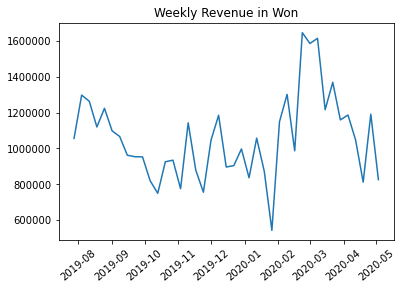

In [14]:
plt.plot(weekly_revenue)
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.title('Weekly Revenue in Won')
plt.xticks(rotation=40)
plt.show()